In [5]:
import torch
# from torch import ones, zeros, eye, as_tensor, tensor, float32, Tensor
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from os import listdir, path
from sbi.analysis import pairplot
from sbi.utils.metrics import c2st as C2ST
from scipy import stats

from gbi import distances
from gbi.benchmark.tasks.uniform_1d.task import UniformNoise1D
from gbi.benchmark.tasks.two_moons.task import TwoMoonsGBI
from gbi.benchmark.tasks.linear_gaussian.task import LinearGaussian
from gbi.benchmark.tasks.gaussian_mixture.task import GaussianMixture

In [2]:
gt_dir = "../results/benchmark/ground_truths/"
inference_dir = "../results/benchmark/algorithms/"
xo_dir = "../gbi/benchmark/tasks/"


task_dict = {
    "uniform_1d": UniformNoise1D,
    "two_moons": TwoMoonsGBI,
    "linear_gaussian": LinearGaussian,
    "gaussian_mixture": GaussianMixture
}

In [28]:
# load xo, gt posterior samples, and inference samples
task_name = "uniform_1d"
if task_name == "gaussian_mixture":
    distance_func = distances.mmd_dist
else:
    distance_func = distances.mse_dist

betas = ["4","20","100"]
algos = ['GBI', 'NPE', 'NLE']
xo_info = (0, 'misspecified', 'known')



In [29]:
# load xos and gt theta
xo_path = f"{xo_dir}/{task_name}/xos/"
with open(f"{xo_path}/xo_{xo_info[1]}_{xo_info[2]}.pkl", 'rb') as handle:
    xos = pickle.load(handle)
    
if xo_info[1]=='specified':
    with open(f"{xo_path}/theta_gt_{xo_info[2]}.pkl", 'rb') as handle:
        theta_gt = pickle.load(handle)
else:
    theta_gt = torch.ones_like(xos)*torch.nan

xo = xos[xo_info[0]]

posterior_samples = {}

# load gt posterior samples
# Take the latest run
gt_datetime = np.sort(listdir(f"{gt_dir}/{task_name}/"))[-1]
posterior_samples['GT'] = {}
for beta in betas:
    gt_path = f"{gt_dir}/{task_name}/{gt_datetime}/beta_{beta}/obs_{xo_info[0]}_{xo_info[1]}_{xo_info[2]}"
    with open(gt_path + "/rejection_samples.pkl", "rb") as handle:
        posterior_samples['GT'][f"beta_{beta}"] = pickle.load(handle)
        

# load inference samples
# algos=["GBI", "NPE"]
run_datetime = np.sort(listdir(f"{inference_dir}/{task_name}/"))[-1]

for algo in algos:
    posterior_dir = f"{inference_dir}/{task_name}/{run_datetime}/{algo}/posterior_inference/"
    
    if algo == "GBI":
        with open(f"{inference_dir}/{task_name}/{run_datetime}/{algo}/inference.pickle", 'rb') as handle:
            gbi_inference = pickle.load(handle)
        
    # Take the latest run
    if path.isdir(posterior_dir):
        posterior_datetime = np.sort(listdir(posterior_dir))[-1]
        print(algo)
        posterior_samples[algo] = {}

        for beta in betas:
            ps_path = f"{posterior_dir}/{posterior_datetime}/beta_{beta}/obs_{xo_info[0]}_{xo_info[1]}_{xo_info[2]}/posterior_samples.pkl"
            # print(ps_path)
            if path.exists(ps_path):
                with open(ps_path, 'rb') as handle:
                    if algo == "GBI":
                        posterior_samples[algo][f"beta_{beta}"] = pickle.load(handle)                    
                    else:
                        posterior_samples[algo] = pickle.load(handle)
            else:
                print(f"{ps_path} does not exist.")

GBI
NPE
../results/benchmark/algorithms//uniform_1d/2023_02_06__19_18_26/NPE/posterior_inference//2023_02_07__00_20_35/beta_4/obs_0_misspecified_known/posterior_samples.pkl does not exist.
../results/benchmark/algorithms//uniform_1d/2023_02_06__19_18_26/NPE/posterior_inference//2023_02_07__00_20_35/beta_20/obs_0_misspecified_known/posterior_samples.pkl does not exist.


In [43]:
# metrics to compute
# C2ST against gt posterior 
# posterior sample mean / std
# distance estimate vs. true distance
# posterior predictive distance mean / std

# compute metrics
beta = betas[1]
theta_posterior_alg = posterior_samples['GBI'][f'beta_{beta}']
theta_posterior_gt = posterior_samples['GT'][f'beta_{beta}']
task = task_dict[task_name](beta=beta, x_o=xo)


0.7447976841310009 0.0 tensor(0.1426)


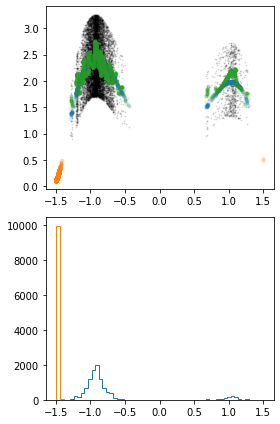

In [48]:
# c2st = C2ST(theta_gt_posterior, theta_posterior)
theta_gt_mean, theta_gt_std = theta_posterior_gt.mean(0), theta_posterior_gt.std(0)
theta_alg_mean, theta_alg_std = theta_posterior_alg.mean(0), theta_posterior_alg.std(0)

# posterior predicitive samples
x_pred_gt = task.simulate(theta_posterior_gt)
x_pred_alg = task.simulate(theta_posterior_alg)

# posterior predicitive distances
dist_pred_true = task.distance_fn(theta_posterior_alg)
dist_pred_gt = task.distance_fn(theta_posterior_gt)
dist_pred_samples = distance_func(x_pred_alg[:,None,:], xo[None,None,:])
with torch.no_grad():
    dist_pred_alg = gbi_inference.distance_net(theta_posterior_alg, xo.repeat((theta_posterior_alg.shape[0], 1))).squeeze(1)


r, pv = stats.pearsonr(dist_pred_true, dist_pred_alg)
dist_error = ((dist_pred_true-dist_pred_alg)**2).mean()**0.5

dist_pred_samples_mean, dist_pred_samples_std = dist_pred_samples.mean(), dist_pred_samples.std()



plt.figure(figsize=(4,6))
plt.subplot(2,1,1)
plt.plot(theta_posterior_alg, dist_pred_samples, 'k.', alpha=0.1, ms=2)
plt.plot(theta_posterior_alg, dist_pred_true, '.', alpha=0.1)
plt.plot(theta_posterior_gt, dist_pred_gt, '.', alpha=0.1)
plt.plot(theta_posterior_alg, dist_pred_alg, '.', alpha=0.1)

plt.subplot(2,1,2)
plt.hist(theta_posterior_alg.squeeze(), 50, histtype='step');
plt.hist(theta_posterior_gt.squeeze(), 50, histtype='step');
plt.axvline(theta_gt[xo_info[0]].squeeze())
plt.tight_layout()
print(r, pv, dist_error)

In [3]:
# %matplotlib inline
# import matplotlib.pyplot as plt

# import pickle
# import os
# import torch
# from torch import Tensor
# import numpy as np
# import time

# import hydra
# from omegaconf import DictConfig, OmegaConf
# from hydra.utils import get_original_cwd, to_absolute_path

# import logging

# from sbi.inference import MCMCPosterior
# from sbi.utils import mcmc_transform
# from sbi.utils.metrics import c2st as C2ST

# from pathlib import Path

# # Algorithm imports.
# from sbi.inference import SNPE, SNLE, likelihood_estimator_based_potential
# from gbi.GBI import GBInference
# import gbi.utils.utils as gbi_utils

# # Task imports.
# from gbi.benchmark.tasks.uniform_1d.task import UniformNoise1D
# from gbi.benchmark.tasks.two_moons.task import TwoMoonsGBI
# from gbi.benchmark.tasks.linear_gaussian.task import LinearGaussian
# from gbi.benchmark.tasks.gaussian_mixture.task import GaussianMixture
# from gbi import distances

# import pandas as pd

In [10]:
def sample_GBI(inference, x_o, beta, task, n_samples=10_000):
    potential_fn = inference.get_potential(x_o=x_o, beta=beta)
    theta_transform = mcmc_transform(task.prior)
    posterior = MCMCPosterior(
            potential_fn,
            theta_transform=theta_transform,
            proposal=task.prior,
            method="slice_np_vectorized",
            thin=10,
            warmup_steps=50,
            num_chains=100,
            init_strategy="resample",
        )
    posterior_samples = posterior.sample((n_samples,))
    return posterior_samples

def sample_NPE(inference, x_o, task, n_samples=10_000):
    return inference.build_posterior(prior=task.prior).set_default_x(x_o).sample((n_samples,))

# inference_nle = gbi_utils.pickle_load(inference_folder + f'NLE.pickle')
# def sample_NLE(inference, x_o, beta, task, n_samples=10_000):
#     potential_fn, parameter_transform = likelihood_estimator_based_potential(
#     inference_nle._neural_net, task.prior, x_o
#     )
#     potential_fn = inference.get_potential(x_o=x_o, beta=beta)
#     theta_transform = mcmc_transform(task.prior)
#     posterior = MCMCPosterior(
#             potential_fn,
#             theta_transform=theta_transform,
#             proposal=task.prior,
#             method="slice_np_vectorized",
#             thin=10,
#             warmup_steps=50,
#             num_chains=100,
#             init_strategy="resample",
#         )
#     posterior_samples = posterior.sample((n_samples,))
#     return posterior_samples

In [9]:
de = posterior_nn("nsf", prior=prior, sigmoid_theta=True)
inference = SNPE(prior=prior, density_estimator=de)

In [13]:
task_name = "two_moons"
seed = 0
# is_specified = 'specified'
# is_known = 'known'
# xo_idx = 0
# beta = 4
betas = [10, 100, 1000]
n_posterior_samples = 10_000

# Get high-level path.
# dir_path = get_original_cwd()

dir_path = '../gbi/benchmark/run_algorithms/'
full_path_prepend = f"{dir_path}/../tasks/{task_name}/"
print(full_path_prepend)

# Get inference directory.
inference_folder = full_path_prepend + "/trained_inference/"    

# Get observation directory.
observation_folder = full_path_prepend + "/xos/"

# Get GT sample directory.
# gt_folder = f'../results/benchmark/ground_truths/{task_name}/2023_01_23__17_34_09/'
gt_folder = '/mnt/slurm_mnt/neuralgbi/results/benchmark/ground_truths/two_moons/2023_01_24__00_56_40/'

../gbi/benchmark/run_algorithms//../tasks/two_moons/


In [ ]:


### Define task and distance function.
distance_func = distances.mse_dist
if task_name == "linear_gaussian":
    Task = LinearGaussian
elif task_name == "two_moons":
    Task = TwoMoonsGBI
elif task_name == "uniform_1d":
    Task = UniformNoise1D
elif task_name == "gaussian_mixture":
    Task = GaussianMixture
    distance_func = distances.mmd_dist
else:
    raise NameError

### Sample and simulate from task.
# Set seed
if seed is None:
    seed = int((time.time() % 1) * 1e7)
else:
    seed = seed
# np.savetxt(full_path_prepend + "seed.txt", np.asarray([seed]))

collector = []
for xo_idx in range(10):
    for beta in betas:
        for is_specified in ['specified', 'misspecified']:
            for is_known in ['known', 'unknown']:
                # Sample and simulate.
                _ = torch.manual_seed(seed)
                _ = np.random.seed(seed=seed)


                # Set ground-truth task.
                x_os = gbi_utils.pickle_load(observation_folder + f'/xo_{is_specified}_{is_known}.pkl')
                x_o = x_os[xo_idx]
                task = Task(seed=seed, x_o=x_o, beta=beta)

                # Load inference object.
                inference_gbi = gbi_utils.pickle_load(inference_folder + f'GBI.pickle')
                inference_npe = gbi_utils.pickle_load(inference_folder + f'NPE.pickle')

                # Sample.
                posterior_samples_gbi = sample_GBI(inference_gbi, x_o, beta, task, n_posterior_samples)
                # posterior_samples_npe = sample_NPE(inference_npe, x_o, task, n_posterior_samples)
                posterior_samples_npe = posterior_samples_gbi
                
                # Ground-truth samples.
                try:
                    posterior_samples_gt = gbi_utils.pickle_load(gt_folder + f'/beta_{beta}/obs_{xo_idx}_{is_specified}_{is_known}/rejection_samples.pkl')
                    posterior_samples_gt = posterior_samples_gt[:n_posterior_samples]
                except:
                    print(f"No GT for beta:{beta}, obs:{xo_idx}, {is_specified}, {is_known}")
                    posterior_samples_gt = torch.zeros(posterior_samples_npe.size())


                # Evaluate.
                # C2ST GBI vs. GT
                c2st = C2ST(posterior_samples_gbi, posterior_samples_gt)

                # Posterior predictive distance.
                ppd_gt = distance_func(task.simulate(posterior_samples_gt).unsqueeze(1), x_o)
                ppd_gbi = distance_func(task.simulate(posterior_samples_gbi).unsqueeze(1), x_o)
                ppd_npe = distance_func(task.simulate(posterior_samples_npe).unsqueeze(1), x_o)

                # Collect.
                summary = [task_name, is_specified, is_known, xo_idx, beta, 
                           float(c2st.squeeze()), float(ppd_gt.mean()), float(ppd_gt.std()), float(ppd_npe.mean()), float(ppd_npe.std()), float(ppd_gbi.mean()), float(ppd_gbi.std())]
                collector.append(summary)

            
col_names = ['task', 'is_specified', 'is_known', 'obs_idx', 'beta', 'c2st', 'ppd_gt_mean', 'ppd_gt_std','ppd_npe_mean', 'ppd_npe_std','ppd_gbi_mean', 'ppd_gbi_std']
dtypes = [str, str, str, int, float, float, float, float, float, float, float, float]
df_summary = pd.DataFrame(np.array(collector), columns=col_names)
df_summary = df_summary.astype({col_names[i]: dtypes[i] for i in range(len(col_names))})
df_summary.to_csv(f'./df_{task_name}.csv')

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

No GT for beta:100, obs:0, misspecified, known


Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

No GT for beta:1000, obs:0, specified, known


Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

No GT for beta:1000, obs:0, misspecified, known


Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

No GT for beta:1000, obs:0, misspecified, unknown


Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

No GT for beta:1000, obs:1, specified, unknown


Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

No GT for beta:1000, obs:1, misspecified, unknown


Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

No GT for beta:100, obs:2, misspecified, known


Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

No GT for beta:1000, obs:2, specified, known


Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

No GT for beta:1000, obs:2, misspecified, known


Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

No GT for beta:1000, obs:2, misspecified, unknown


Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

Running vectorized MCMC with 100 chains:   0%|          | 0/150000 [00:00<?, ?it/s]

In [16]:
col_names = ['task', 'is_specified', 'is_known', 'obs_idx', 'beta', 'c2st', 'ppd_gt_mean', 'ppd_gt_std','ppd_npe_mean', 'ppd_npe_std','ppd_gbi_mean', 'ppd_gbi_std']
dtypes = [str, str, str, int, float, float, float, float, float, float, float, float]
df_summary = pd.DataFrame(np.array(collector), columns=col_names)
df_summary = df_summary.astype({col_names[i]: dtypes[i] for i in range(len(col_names))})
df_summary.to_csv(f'./df_{task_name}.csv')

In [15]:
len(collector)

120

In [282]:



# plt.hist(ppd_gbi.squeeze(), 100);
# plt.hist(ppd_npe.squeeze(), 100);
# c2st

specified known
specified unknown
misspecified known
misspecified unknown


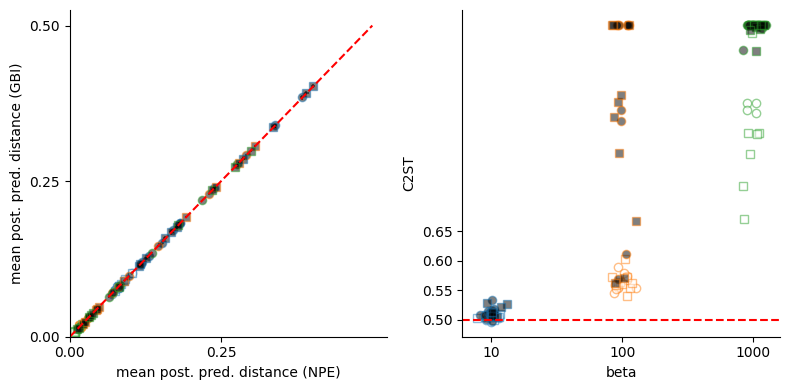

In [17]:
# with plt.rc_context(fname="../.matplotlibrc"):
plt.figure(figsize=(8,4))
markers = ['*', 'o', 's', '^']
ctr = 0
for i_s, is_specified in enumerate(['specified', 'misspecified']):
    for i_k, is_known in enumerate(['known', 'unknown']):
        print(is_specified, is_known)
        df_curr = df_summary[(df_summary['is_specified']==is_specified) & (df_summary['is_known']==is_known)]
        
        
        for i_r, (beta, rows) in enumerate(df_curr.groupby('beta')):
            plt.subplot(1,2,1)
            plt.errorbar(rows['ppd_npe_mean'].values, rows['ppd_gbi_mean'].values, 
                         xerr=rows['ppd_npe_std'].values/100*3, yerr=rows['ppd_gbi_std'].values/100*3, fmt=f'k', ls='', alpha=0.5)

            plt.plot(rows['ppd_npe_mean'].values, rows['ppd_gbi_mean'].values, 
                     f'C{i_r}', 
                     mfc='k' if i_s==1 else 'w', 
                     marker='o' if i_k==0 else 's',
                     mew=1,
                     ls='',
                     alpha=0.5)
        
            plt.subplot(1,2,2)
            plt.plot(i_r*np.ones_like(rows['c2st'])+np.random.randn(len(rows))*0.05, rows['c2st'], f'C{i_r}', 
                     mfc='k' if i_s==1 else 'w', 
                     marker='o' if i_k==0 else 's',
                     mew=1,
                     ls='',
                     alpha=0.5
                    )
        ctr+=1

plt.subplot(1,2,1)
plt.plot([0,.5], [0,.5], 'r--')
plt.xlabel('mean post. pred. distance (NPE)'); plt.ylabel('mean post. pred. distance (GBI)'); 
plt.xlim([0, None]);    plt.ylim([0, None]);
plt.xticks([0,0.25]);plt.yticks([0,0.25, 0.5]);
plt.gca().spines[['right', 'top']].set_visible(False)

plt.subplot(1,2,2)
plt.axhline(0.5, color='r', ls='--')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.xlabel('beta');plt.ylabel('C2ST'); 
plt.xticks([0,1,2], labels=betas);plt.yticks([0.5, 0.55, 0.6, 0.65]);

plt.tight_layout()

In [117]:

def tempered_potential(potential_fn, beta):
    return potential_fn(posterior_samples)

tensor([-0.4540, -0.4283, -0.3058,  ..., -0.3525, -0.3588, -0.6657],
       grad_fn=<AddBackward0>)

In [94]:
posterior_predictives = task.simulate(posterior_samples)

(tensor([0.0069, 0.0276, 0.0002,  ..., 0.0494, 0.0203, 0.0225]),
 tensor([0.0069, 0.0276, 0.0002,  ..., 0.0494, 0.0203, 0.0225]))

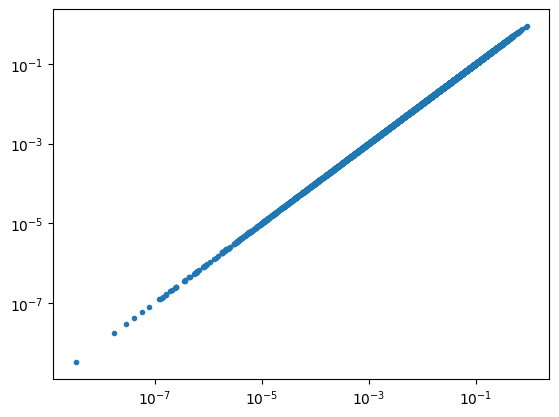

In [97]:

ppd = distance_func(posterior_predictives.unsqueeze(1), x_o)

plt.loglog(ppd, (posterior_predictives-x_o).pow(2).mean(1), '.')
ppd, (posterior_predictives-x_o).pow(2).mean(1)

In [69]:
c2st(posterior_samples, gt_samples)

tensor([0.8349])

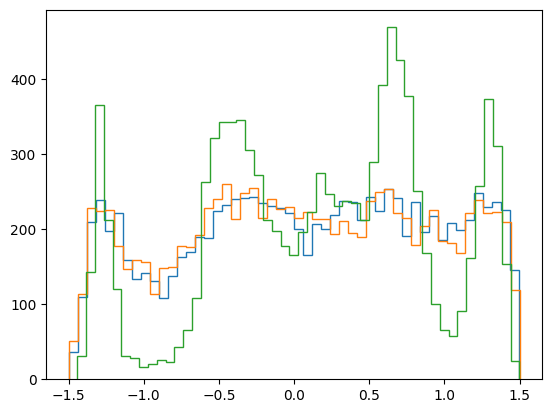

In [107]:
# plt.plot(gt_samples, torch.ones(gt_samples.size()), '.', alpha=0.1)
plt.hist(gt_samples.numpy().squeeze(), 50, histtype='step');
plt.hist(posterior_samples.numpy().squeeze(), 50, histtype='step');
plt.hist(posterior_samples_npe.numpy().squeeze(), 50, histtype='step');

# c2st(posterior_samples, gt_samples)

In [ ]:
task = UniformNoise1D()

# Train inference algorithms.
task.dist_func_gbi = distance_func

# Get trained inference object.
inference = gbi_utils.pickle_load(inference_folder + 'NPE.pickle')
print(inference)